In [77]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pystan

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

In [78]:
output = pd.read_csv('../data/output_back.csv', usecols=[1,11,24])
#IDs = [(output.loc[output['ID'] == random.choice(output['ID'])]).iloc[0]['Numax'] for i in range(5)]

noStars = 50
# Select a random sample of stars from the file, recording their IDs
IDs = [random.choice(output['kic']) for i in range(noStars)]
# Create a list of the numax values corresponding to each ID
Numax = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax'] for i in range(len(IDs))]
Numax_err = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax_err'] for i in range(len(IDs))]

print(IDs)

[9145952, 10467570, 3457618, 10721900, 11083319, 7025721, 6755907, 7595285, 11129945, 4041405, 3114408, 10816214, 10667886, 4445711, 11232225, 2569945, 9472481, 12168406, 11767058, 10753962, 5024601, 5024967, 4036300, 11177727, 11598312, 2437653, 10148026, 6181896, 11517524, 3736477, 12168406, 9163153, 8693004, 8804395, 10090400, 10979742, 1726211, 2695267, 2570172, 10483504, 9002344, 11231549, 8759811, 10552614, 10163776, 7510604, 9273827, 4902701, 8934264, 9839246]


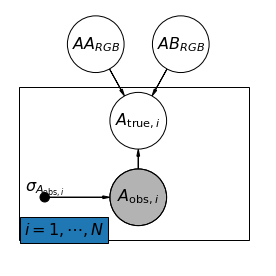

In [79]:
from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=3, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("AA", r"$AA_{RGB}$", 1.0, 2.6))
pgm.add_node(daft.Node("AB", r"$AB_{RGB}$", 2.0, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("A_true", r"$A_{{\rm true},i}$", 1.5, 1.7))
# Data.
pgm.add_node(daft.Node("A_obs", r"$A_{{\rm obs},i}$", 1.5, 0.8, observed=True))
pgm.add_node(daft.Node("Aerr", r"$\sigma_{A_{{\rm obs},i}}$", 0.4, 0.8, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("AA", "A_true")
pgm.add_edge("AB", "A_true")
pgm.add_edge("A_obs", "A_true")
pgm.add_edge("Aerr", "A_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

In [80]:
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0']) for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)
arr_n = np.zeros([len(IDs),maxmodes])
arr_freq = np.zeros([len(IDs),maxmodes])
arr_freqerr = np.zeros([len(IDs),maxmodes])


dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 100000}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            #modesID[i].loc[l] = [l, int(np.max(modesID[i]['n']+l)), (np.max(modesID[i]['dnu'])+dnu_avgID[i]), np.nan , 10000]
            #app = pd.DataFrame([(np.max(modesID[i]['dnu'])+dnu_avgID[i]), 10000], columns=['n', 'f0', 'f0_err'])
            #modesID[i].append(app, ignore_index=True)
            l += 1
        
    arr_n[i,:] = modesID[i]['n']
    arr_freq[i,:] = modesID[i]['f0']
    arr_freqerr[i,:] = modesID[i]['f0_err']
    
    #display(modesID[i])
dnu_avgarr = np.asarray(dnu_avgID)

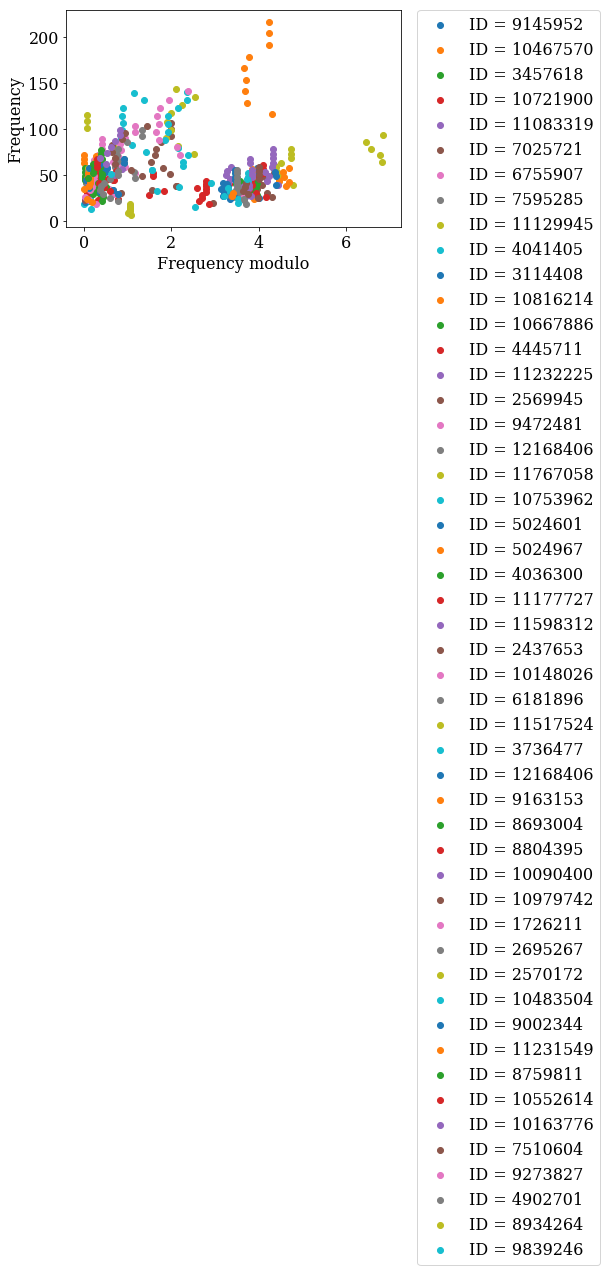

In [81]:
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

#Define start parameters
eps = []
for i in range(len(IDs)):
    epsilon1 = np.median((modesID[i].f0 % dnu_avg) / dnu_avg)
    eps.append(epsilon1)
epsilon = np.asarray(eps)

numax_obs = Numax
numax_err = Numax_err
nmax = numax_obs/dnu_avgarr - epsilon
alpha = 0.015*dnu_avgarr**(-0.32)
A = 0.06*dnu_avgarr**(-0.88) 
G = np.ones([len(IDs)])*3.08
tau = np.ones([len(IDs)])*10
phi = np.ones([len(IDs)])*1.71

plt.ylabel('Frequency')
plt.xlabel(r'Frequency modulo')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [82]:
code = '''
functions{
    real vrard(real n, real dnu, real nmax, real epsilon, real alpha, real A, real G, real phi, real tau){
        return (n + epsilon + (alpha/2) * (nmax - n)^2 + 
                A*G/(2*pi()) * sin((2*pi()*(n-nmax))/G + phi))*dnu;
                //*exp(-n/tau);
    }
}
data {
    int N;  //number of stars
    int M; //number of modes
    real n[N, M];
    real freq[N, M];
    real freq_err[N, M];
    real dnu_guess[N];
    real numax_obs[N];
    real numax_err[N];
}
parameters {
    real dnu[N];
    real<lower = 0> numax[N];
    real epsilon_std[N];
    real<lower = 0> eps_sig;
    real alpha_std[N];
    real<lower = 0> al_sig;
    real A_std[N];
    real<lower = 0> A_sig;
    real<lower = 0> G[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];
    real<lower = 0> tau[N];
    real epsA;
    real epsB;
    real alA;
    real alB;
    real AA;
    real AB;
    
}

transformed parameters{
    real epsilon[N];
    real alpha[N];
    real A[N];
    for (i in 1:N){
        epsilon[i] = epsilon_std[i] * eps_sig + (epsA + epsB * log(dnu[i]));
        alpha[i] = alpha_std[i] * al_sig + (alA * (dnu[i])^(-alB));
        A[i] = A_std[i] * A_sig + (AA*dnu[i]^(-AB));
    }
}
model {
    real mod[M];
    real nmax[N];
    for (i in 1:N){
        nmax[i] = numax[i]/dnu[i] - epsilon[i];
        for (j in 1:M){
            mod[j] = vrard(n[i,j], dnu[i], nmax[i], epsilon[i], alpha[i], A[i], G[i], phi[i], tau[i]);
            //mod[j] ~ normal(freq[i], freq_err[i]);
        }
        freq[i,:] ~ normal(mod, freq_err[i,:]);
        numax[i] ~ normal(numax_obs[i], numax_err[i]);
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.01);
        //epsilon[i] ~ normal(epsA + epsB*log(dnu[i]), 0.5);
        //alpha[i] ~ lognormal(log(alA*dnu[i]^(-alB)), 0.3);
        //A[i] ~ lognormal(log(AA*dnu[i]^(-AB)), 0.4);
        //epsilon[i] ~ uniform(-1.0, 2.0);
        //alpha[i] ~ lognormal(log(0.015*dnu[i]^(-0.32)), 0.5);
        //A[i] ~ lognormal(log(0.06*dnu[i]^(-0.88)), 0.6);
    }
    nmax ~ normal(10, 4);
    G ~ normal(3.08, 0.65);
    tau ~ normal(20, 10);
    epsilon_std ~ normal(0, 1);
    eps_sig ~ normal(0, 0.5);
    epsA ~ normal(0.601, 0.08);
    epsB ~ normal(0.632, 0.08);
    alpha_std ~ normal(0, 1);
    al_sig ~ normal(0, 0.5); 
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    A_std ~ normal(0, 1);
    A_sig ~ normal(0, 0.5);
    AA ~ normal(0.06, 0.01);
    AB ~ normal(0.88, 0.05);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b1e62cf12736dd6d63fdd494165e93e0 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmp_d18j86p/stanfit4anon_model_b1e62cf12736dd6d63fdd494165e93e0_2228693852983149441.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [83]:
stan_data = {'N': len(IDs),
         'M': maxmodes,
         'n': arr_n, 
         'freq': arr_freq,
         'freq_err': arr_freqerr,
         'dnu_guess': dnu_avgarr,
         'numax_obs': numax_obs,
         'numax_err': numax_err
        }
start = {'dnu': dnu_avgarr,
         'nmax': nmax,
         'numax': numax_obs,
         #'epsilon': epsilon,
         #'alpha': alpha,
         #'A': A,
         'eps_sig': 0.01,
         'al_sig': 0.01,
         'A_sig': 0.01,
         'G': G,
         'tau': tau,
         'phi': phi,
         'epsA': 0.601,
         'epsB': 0.632,
         'alA': 0.015,
         'alB': 0.32,
         'AA': 0.06,
         'AB': 0.88
    }
nchains = 4

fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

In [84]:
print(fit)

Inference for Stan model: anon_model_b1e62cf12736dd6d63fdd494165e93e0.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[1]            4.07  4.4e-4   0.01   4.04   4.06   4.07   4.07   4.09    737   1.01
dnu[2]            4.01  4.9e-4   0.01   3.99   4.01   4.01   4.02   4.03    542    1.0
dnu[3]            3.59  2.5e-4 6.0e-3   3.58   3.58   3.59   3.59    3.6    574   1.01
dnu[4]            3.52  3.0e-3   0.03   3.47   3.51   3.52   3.54   3.58     82   1.06
dnu[5]            4.19  6.0e-4   0.01   4.17   4.18   4.19    4.2   4.21    374   1.01
dnu[6]            4.31  3.1e-4 9.4e-3   4.29    4.3   4.31   4.31   4.33    927    1.0
dnu[7]            4.81  2.5e-4 8.1e-3   4.79    4.8   4.81   4.81   4.82   1033    1.0
dnu[8]            3.76  3.1e-4 8.0e-3   3.75   3.76   3.76   3.77   3.78    660    1.0
dnu[9]            4.82  5.9

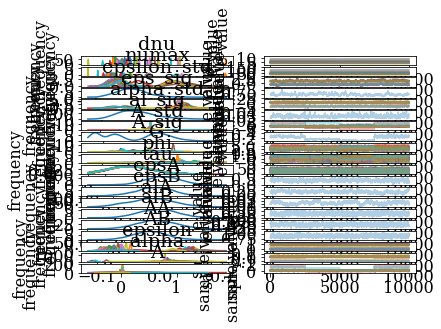

In [85]:
fit.plot()
plt.show()

In [86]:
def model(n, dnu, numax, epsilon, alpha, A, G, phi, tau):
    nmax = numax/dnu - epsilon
    freqs = (n + epsilon + (alpha/2) * (n - nmax)**2 + ((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi)) * dnu# * np.exp(-n/tau)
    return freqs

In [87]:
#for i in range(len(IDs)):
    #print(np.mean(modesID[i]['dnu']))

#for i in range(len(IDs)):
    #print(np.mean(fit['G'], axis=0)[i])

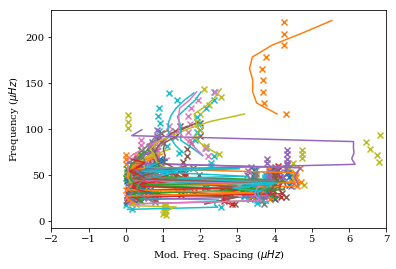

In [88]:
%matplotlib inline
for i in range(len(IDs)):
    plt.figure(len(IDs))
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    #np.mean(modesID[i]['dnu'])
    g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], 33) #np.mean(fit['tau'], axis=0)[i])
    plt.plot(g2 % np.mean(fit['dnu'],axis=0)[i], g2, label='Fit_2D')

plt.ylabel('Frequency ($\mu Hz$)')
plt.xlabel(f'Mod. Freq. Spacing ($\mu Hz$)')
plt.xlim(-2,7)
plt.show()



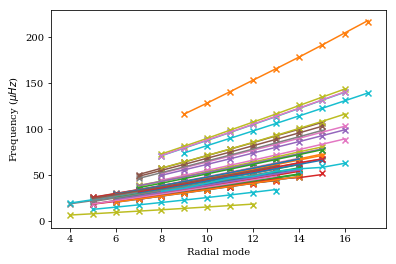

In [89]:
for i in range(len(IDs)):
    plt.figure(len(IDs))
    plt.scatter(modesID[i]['n'], modesID[i]['f0'], marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    #np.mean(modesID[i]['dnu'])
    g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], 33) #np.mean(fit['tau'], axis=0)[i])
    plt.plot(arr_n[i], g2, label='Fit_2D')

plt.ylabel('Frequency ($\mu Hz$)')
plt.xlabel(f'Radial mode')
plt.show()

Text(0.5, 0.98, 'Parameters plotted against $\\langle \\Delta \\nu \\rangle$')

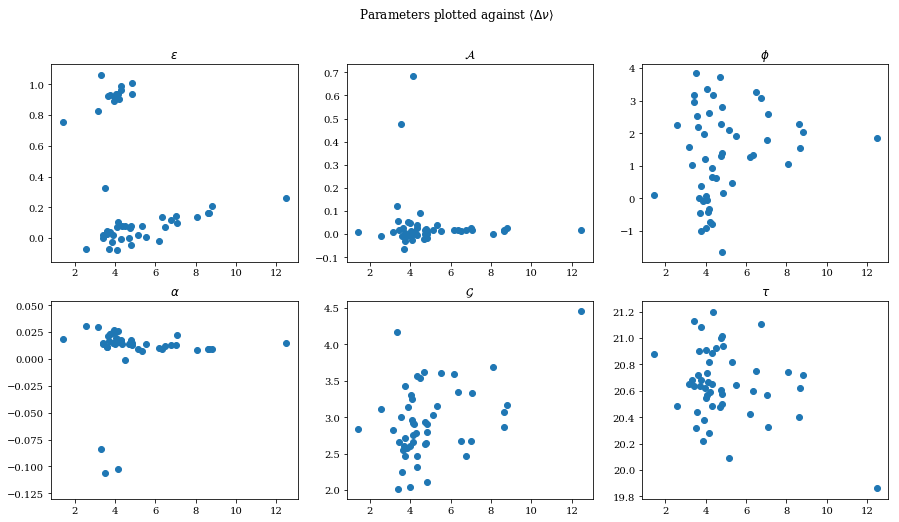

In [90]:
dnus = []
epsilons = []
alphas = []
As = []
Gs = []
phis = []
taus = []
for i in range(len(IDs)):
    dnus.append(np.mean(fit['dnu'],axis=0)[i])
    epsilons.append(np.mean(fit['epsilon'],axis=0)[i])
    alphas.append(np.mean(fit['alpha'],axis=0)[i])
    As.append(np.mean(fit['A'],axis=0)[i])
    Gs.append(np.mean(fit['G'],axis=0)[i])
    phis.append(np.mean(fit['phi'],axis=0)[i])
    taus.append(np.mean(fit['tau'],axis=0)[i])
    
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False, sharex=False)
axs[0,0].scatter(dnus, epsilons)
axs[0,0].set_title(r'$\epsilon$')
axs[1,0].scatter(dnus, alphas)
axs[1,0].set_title(r'$\alpha$')
axs[0,1].scatter(dnus, As)
axs[0,1].set_title(r'$\mathcal{A}$')
axs[1,1].scatter(dnus, Gs)
axs[1,1].set_title(r'$\mathcal{G}$')
axs[0,2].scatter(dnus, phis)
axs[0,2].set_title(r'$\phi$')
axs[1,2].scatter(dnus, taus)
axs[1,2].set_title(r'$\tau$')
fig.suptitle(r'Parameters plotted against $\langle \Delta \nu \rangle$')

In [17]:
import corner
data = np.vstack([fit['epsilon'], fit['alpha'], fit['dnu'], fit['nmax'],
                  fit['a'], fit['omega'], fit['phi'], fit['tau']]).T
corner.corner(data, labels=[r'$\epsilon$', r'$k$',r'$\Delta\nu$',r'$n_{max}$',
                            r'$A$', r'$\omega$', r'$\phi$', r'$\tau$'])
              #, truths=[1.436, 0.07, 0.3, 2, 0])
plt.show()

ValueError: No parameter a